# Quantum Variational Circuit
In this notebook we will implement a quantum variational circuit (QVC), we use it as a binary classificator for detecting entanglement in a quantum state.

In [2]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

## Dataset

The dataset contains 10,000 examples consisting of 10 features and a binary label: _sep_. The feature are rappresente as observable generated from a determined quantum state


In [33]:
# Number of total exemples 
n_exemples = 10000

# Loading dataset with pandas
dataset = pd.read_csv('../datasets/ds_haar_op.csv')
dataset = dataset[:n_exemples]

In [34]:
# Dividing dataset in features and label
X = dataset.to_numpy(dtype=np.csingle)[:,0:16]
y = dataset.to_numpy()[:,-1]

# Redifining labels on -1,1
y = np.array(2 * (y - 0.5),dtype=int)

In [35]:
# Spliting dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 8000
Test size: 2000


In [42]:
# Setting the number of qbits the same as the number of features
n_qubits = 4
print("Number of Qbits: ",n_qubits)

Number of Qbits:  4


## Quantum Circuit

In [45]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    qml.AmplitudeEmbedding(x,wires=range(n_qubits),normalize=True)

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

## Functions

In [22]:
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

## Training and test

step 0 , loss 0.9771198217840095
step 10 , loss 0.986013220940344
step 20 , loss 0.9206180958077248
step 30 , loss 0.9242016699061664
step 40 , loss 0.9044649812637946
step 50 , loss 1.0060533966083773
step 60 , loss 1.0932785473409719
step 70 , loss 0.9768281294992265
step 80 , loss 1.0117360465944454
step 90 , loss 0.9417839166057203
accuracy on test set: 0.4875


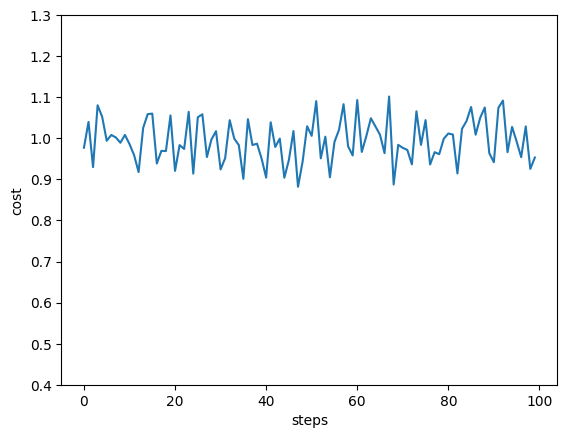

In [48]:
n_layers = 4
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0.4, 1.3))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()